In [1]:
!pip install plotly

!pip install seaborn
!pip install nltk
!pip install gensim
!pip install yellowbrick

In [19]:
#importing libraries
import pandas as pd 
import numpy as np
import nltk 
import plotly.express as px
import gensim
import gc
import string
import re
import yellowbrick
#import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots

#cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

In [21]:
df_ny=pd.read_csv("C:/Users/u/Documents/Glassdoor jobs/Data_Job_NY.csv")
df_ny

Job_title  \
0                            Chief Marketing Officer (CMO)   
1                                         Registered Nurse   
2                                         Dental Hygienist   
3                              Senior Salesforce Developer   
4    DEPUTY EXECUTIVE DIRECTOR, PROGRAM AND LEGAL ADVOCACY   
..                                                     ...   
895                                               RN / LPN   
896                                Ultrasound Technologist   
897                              NYS Licensed Psychologist   
898                      Lead Pharmacy Technician: Billing   
899                           Experienced A level mechanic   

                                   Company State           City  Min_Salary  \
0                     National Debt Relief    NY       New York          -1   
1        Queens Boulevard Endoscopy Center    NY      Rego Park          -1   
2                           Batista Dental    NJ  West New York          -1   
3                     National Debt Relief    NY       New York       44587   
4    National Advocates for Pregnant Women    NY       New York      125410   
..                                     ...   ...            ...         ...   
895        Star Pediatric Home Care Agency    NJ    Jersey City       48000   
896               Middle Village Radiology    NY      Rego Park       55069   
897          The Senior Citizen Care Group    NY          Bronx          -1   
898                         Medly Pharmacy    NY       Brooklyn          -1   
899                         Motorwerks inc    NY     Mamaroneck       21402   

     Max_Salary  \
0            -1   
1            -1   
2            -1   
3         82162   
4        212901   
..          ...   
895       75000   
896       74745   
897          -1   
898          -1   
899       52210   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [26]:
df_ny.shape

(900, 12)

In [27]:
df_ny.head

<bound method NDFrame.head of                                                  Job_title  \
0                            Chief Marketing Officer (CMO)   
1                                         Registered Nurse   
2                                         Dental Hygienist   
3                              Senior Salesforce Developer   
4    DEPUTY EXECUTIVE DIRECTOR, PROGRAM AND LEGAL ADVOCACY   
..                                                     ...   
895                                               RN / LPN   
896                                Ultrasound Technologist   
897                              NYS Licensed Psychologist   
898                      Lead Pharmacy Technician: Billing   
899                           Experienced A level mechanic   

                                   Company State           City  Min_Salary  \
0                     National Debt Relief    NY       New York          -1   
1        Queens Boulevard Endoscopy Center    NY      Rego Park    

In [28]:
df_ny.tail

<bound method NDFrame.tail of                                                  Job_title  \
0                            Chief Marketing Officer (CMO)   
1                                         Registered Nurse   
2                                         Dental Hygienist   
3                              Senior Salesforce Developer   
4    DEPUTY EXECUTIVE DIRECTOR, PROGRAM AND LEGAL ADVOCACY   
..                                                     ...   
895                                               RN / LPN   
896                                Ultrasound Technologist   
897                              NYS Licensed Psychologist   
898                      Lead Pharmacy Technician: Billing   
899                           Experienced A level mechanic   

                                   Company State           City  Min_Salary  \
0                     National Debt Relief    NY       New York          -1   
1        Queens Boulevard Endoscopy Center    NY      Rego Park    

In [29]:
df_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Job_title    900 non-null    object 
 1   Company      900 non-null    object 
 2   State        900 non-null    object 
 3   City         900 non-null    object 
 4   Min_Salary   900 non-null    int64  
 5   Max_Salary   900 non-null    int64  
 6   Job_Desc     900 non-null    object 
 7   Industry     600 non-null    object 
 8   Rating       660 non-null    float64
 9   Date_Posted  900 non-null    object 
 10  Valid_until  900 non-null    object 
 11  Job_Type     900 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 84.5+ KB


In [31]:
#conversion of the minimum and maximum salary into integer
df_ny['Min_Salary'] = df_ny['Min_Salary'].apply(lambda x : int(x))
df_ny['Max_Salary'] =df_ny['Max_Salary'].apply(lambda x : int(x))


In [32]:
#Extracting date and day from Date_Posted : data is the format y-m-d
import calendar
df_ny['Month'] = df_ny['Date_Posted'].apply(lambda x : calendar.month_abbr[int(str(x).split('-')[1])]) 
#df_ny['Month'] = df_ny['Month'].apply(lambda x : calendar.month_abbr[int(x)])

In [33]:
def Convert_to_Day(x):
    sl = x.split('-')
    
    return calendar.day_abbr[int(calendar.weekday(int(sl[0]) , int(sl[1]) , int(sl[2])))]

df_ny['Day'] = df_ny['Date_Posted'].apply(lambda x : Convert_to_Day(x))

In [34]:
#While collecting the data if no salary is found I replaced the value by -1 so lets store that data in different data frame
index_missing = df_ny[(df_ny['Min_Salary'] == -1)].index
test_df = df_ny.iloc[index_missing, :].reset_index(drop = True)
df_ny.drop(index_missing , axis = 0 , inplace = True)
df_ny = df_ny.reset_index(drop = True)
#We will use this data as our test set.

In [37]:
#Now that we have train and test set there are duplicates in the data becasue our scraper was not perfect and could havea assimilated multiple entries

cols = [col for col in df_ny.columns if col not in ['Day' , 'Month']]
#For training data 
train_series =df_ny.duplicated(cols , keep = 'first')
df_ny =df_ny[~train_series].reset_index(drop = True)
test_series = test_df.duplicated(cols , keep = 'first')
test_df = test_df[~test_series].reset_index(drop = True)

In [38]:
#Unique States

print(df_ny['State'].unique())

['NY' 'NJ']


In [39]:
#Let's explore the top 5 cites in which most job lisitngs are there
for state in df_ny['State'].unique():
    print(f"State of {state}")
    print(df_ny[df_ny['State'] == state]['City'].value_counts()[:5])

State of NY
New York          8
Williston Park    1
Brooklyn          1
Maspeth           1
Staten Island     1
Name: City, dtype: int64
State of NJ
Jersey City    2
Paramus        1
Name: City, dtype: int64


In [84]:
#Pie Chart of CA and NY

max_state = ['NY' , 'NJ']
fig = make_subplots(rows = 1 , cols =2 , specs=[[{'type':'domain'}, {'type':'domain'}]])
for i,state in enumerate(max_state,1):
    cities = df_ny[df_ny['State'] == state]['City'].value_counts()[:5].index.to_list()
    counts = df_ny[df_ny["State"] == state]['City'].value_counts()[:5].to_list()
    fig.add_trace(go.Pie(labels = cities ,values = counts  ,name = state),1,i)
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="States with most number of jobs",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text= 'NY', x=0.20, y=0.5, font_size=25, showarrow=False),
                 dict(text='NJ', x=0.82, y=0.5, font_size=25, showarrow=False)])
fig.show()

In [87]:
#Let's the avg minimal salaries for states 
import numpy as np
states = df_ny['State'].unique().tolist()
fig = go.Figure()
min_sal =  df_ny.groupby('State')['Min_Salary']
max_sal =  df_ny.groupby('State')['Max_Salary']
fig.add_trace(go.Bar(x = states,
                    y = min_sal.mean(),
                    name = 'Min Salary' , marker_color = 'Magenta'))

fig.add_trace(go.Bar(x = states,
                    y = max_sal.mean(),
                    name = 'Max Salary' , marker_color = 'SkyBlue'))
fig.update_layout(template = 'ggplot2', barmode = 'group')
fig.show()

In [94]:
#Let's see avg minimal salaries according to top  5 cities 
states = ["NY"]
fig = make_subplots(rows = 3 , cols = 1,specs = [[{"type": "xy"}],[{"type": "xy"}],[{"type": "xy"}]])
colors = ['#2e9dd4' ,'#e76969' ,'#4fd882' ,'#f22dea' , '#e7468f']
for i,state in enumerate(states,1):

    cities = df_ny[df_ny['State'] == state]['City'].value_counts()[:5].index.to_list()
    avg_min_sals = []
    for city in cities:
        

        avg_min_sals.append(int(df_ny[df_ny['City'] == city]['Min_Salary'].mean()))
    fig.add_trace(go.Bar(x = cities , y = avg_min_sals  ,marker_color = colors ,name = state),i,1)
    fig.update_layout(template = 'ggplot2' , title = "Average Minimal Salaries per city in states with most number of Jobs")
fig.show()

In [95]:
#Job Types in States with Max number of Jobs
for state in states:
    print(f"Type of Jobs in state of {state}")
    print(df_ny[df_ny['State'] == state]['Job_Type'].value_counts())

Type of Jobs in state of NY
FULL_TIME    13
PART_TIME     1
Name: Job_Type, dtype: int64


In [96]:
#Let's see the day on which most number of jobs are posted
day_fig = go.Figure([go.Bar(x = df_ny['Day'].value_counts().index.to_list() ,
                    y = df_ny['Day'].value_counts().to_list() , marker_color = 'skyblue')])
day_fig.update_layout(template = 'ggplot2' , title = 'Days with max number of jobs')


In [97]:
#Now's  let's explore the industry column
#This column has Nan Values

ind = df_ny[~df_ny['Industry'].isnull()]
print(f"Number of Unique Industries : {ind.Industry.nunique()}")

Number of Unique Industries : 7


In [98]:
ind.Industry.value_counts()

Finance                               3
Health Care                           2
Construction, Repair & Maintenance    2
Information Technology                1
Telecommunications                    1
Biotech & Pharmaceuticals             1
Retail                                1
Name: Industry, dtype: int64

In [99]:
#top 8 industries with max number of jobs

fig = go.Figure()
fig.add_traces(go.Pie(values = ind.Industry.value_counts()[:8].to_list(),
                    labels= ind.Industry.value_counts()[:8].index.to_list(),
                    name = 'Industry',textposition = 'inside' , textinfo = 'percent+label'))
fig.update_layout(template = 'plotly_white',title = 'Industries with most number of Data Science Related jobs' )
fig.show()

In [100]:
#Let's see which industries dominate the states 
for state in ind.State.unique():
    print(f"State of {state}")
    print(ind[ind['State'] == state]['Industry'].value_counts()[:8])

State of NY
Finance                               3
Health Care                           2
Construction, Repair & Maintenance    2
Information Technology                1
Telecommunications                    1
Biotech & Pharmaceuticals             1
Retail                                1
Name: Industry, dtype: int64


In [101]:
#Lets take a look at minimal average salary for the top 8 industries
fig = go.Figure()
fig.add_trace(go.Bar(x = ind.groupby("Industry")['Min_Salary'].mean().to_list(),
y = ind.groupby("Industry")['Min_Salary'].mean().index.to_list(), marker_color = 'goldenrod',
orientation = 'h' , name = "Min Avg Salary"
))
fig.add_trace(go.Bar(x = ind.groupby("Industry")['Max_Salary'].mean().to_list(),
y = ind.groupby("Industry")['Max_Salary'].mean().index.to_list(), marker_color = 'deepskyblue'
,orientation = 'h' ,name = "Max Avg Salary"))
fig.update_layout( template = 'plotly_dark',
    title = 'Minimal And Maximal Average Annual Salaries according to industries' ,barmode = 'group')
fig.show()

In [102]:
#Now let's explore companies 

print(f"Number of Unique Company Names : {df_ny['Company'].nunique()}")

Number of Unique Company Names : 13


In [103]:
# Companies which have most number of job postings

fig = go.Figure()
fig.add_trace(go.Bar(y = df_ny['Company'].value_counts()[:20].to_list(),
x= df_ny['Company'].value_counts()[:20].index.to_list(),
marker_color = 'deepskyblue' , name = "Company"))
fig.update_layout(title= 'Companies with Max Number of Job Postings related to data science',
                template = 'plotly_dark')
fig.show()

In [104]:
#Let's take a look at Avg Minimal and Maximal salaries for companies 
def Plot_Company_salaries(companies,title):
    fig = go.Figure()
    min_sal = []
    max_sal = []
    for company in companies:
        min_sal.append(df_ny[df_ny['Company'] == company]['Min_Salary'].mean())
        max_sal.append(df_ny[df_ny['Company'] == company]['Max_Salary'].mean())



    fig.add_trace(go.Bar(x = min_sal ,y = companies , marker_color = 'deepskyblue' 
    , name  = 'Minimal Salary' , orientation = 'h'))
    fig.add_trace(go.Bar( x= max_sal,y = companies , marker_color = 'red' , 
    name = 'Maximal Salary', orientation = 'h'))
    
    fig.update_layout(title = title,
    barmode = 'group' , template = 'plotly_dark')
    fig.show()
    

In [106]:
#Top 5 companies in NY
states = ['NY']
companies = []
titles = []
for state in states:
    companies.append(df_ny[df_ny['State'] == state]['Company'].value_counts()[:5].index.to_list())
    titles.append(f'{state} : Minimal And Maximal Annual Average Salaries for top 5 companies')

for i in range(len(states)):
    Plot_Company_salaries(companies[i] , titles[i])

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



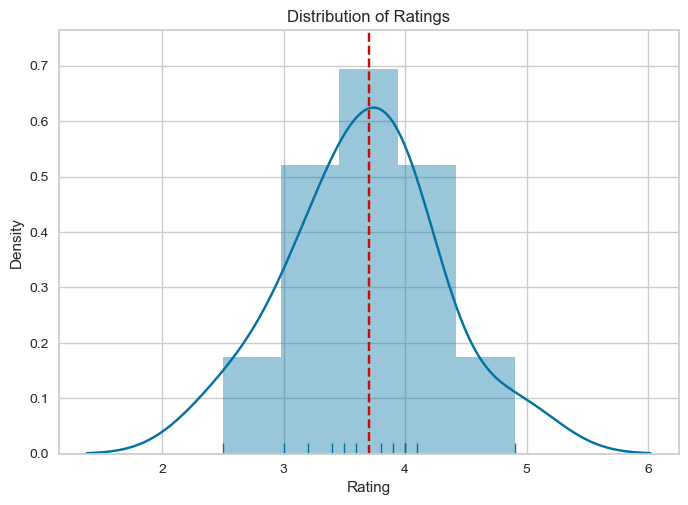

In [107]:
#Distribution of ratings of companies

ratings =df_ny[~df_ny['Rating'].isnull()]['Rating']
sns.distplot(ratings,kde = True , rug = True)
plt.axvline(np.median(ratings),color='r', linestyle='--')
plt.grid(True)
plt.title("Distribution of Ratings")
plt.show()

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



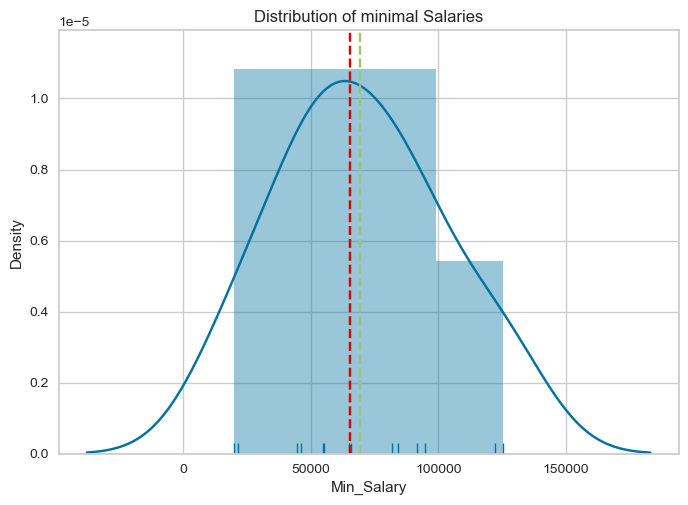

In [108]:
#Minimal Salaries distribution
sns.distplot(df_ny['Min_Salary'] , kde = True , rug = True)
plt.axvline(np.median(df_ny['Min_Salary']),color='r', linestyle='--')
plt.axvline(np.mean(df_ny['Min_Salary']),color='g', linestyle='--')
plt.grid(True)
plt.title("Distribution of minimal Salaries")
plt.show()

In [112]:
#Box plot for minimal salaries
fig = px.box(df_ny , y = 'Min_Salary' ,points = 'all')
fig.show()

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\u\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



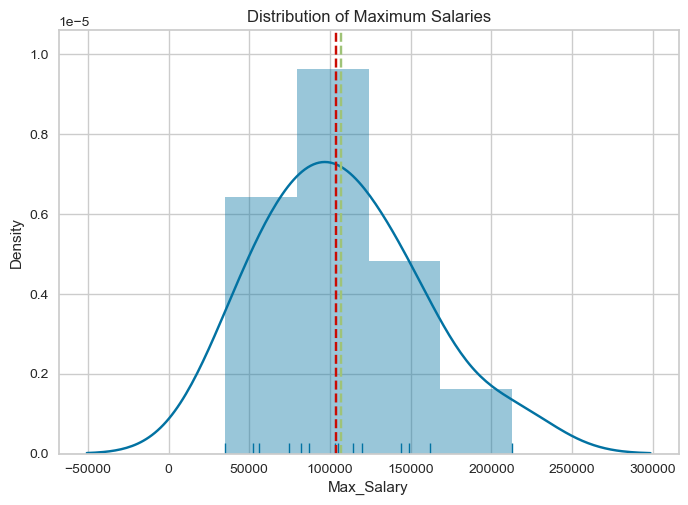

In [110]:
#Maximal Salaries distribution
sns.distplot(df_ny['Max_Salary'] , kde = True , rug = True)
plt.axvline(np.median(df_ny['Max_Salary']),color='r', linestyle='--')
plt.axvline(np.mean(df_ny['Max_Salary']),color='g', linestyle='--')
plt.grid(True)
#plt.figure(figsize=(100,100))
plt.title("Distribution of Maximum Salaries")
plt.show()

In [111]:
#Box plot for maximal salaries
fig = px.box(df_ny , y = 'Max_Salary' ,points = 'all')
fig.show()

In [113]:
#unique Job titles
df_ny['Job_title'].nunique()

14

In [115]:
#Top 8 job titles with max jobs
fig = go.Figure()
fig.add_traces(go.Pie(values = df_ny.Job_title.value_counts()[:8].to_list(),
                    labels= df_ny.Job_title.value_counts()[:8].index.to_list(),
                    name = 'Job Title',textposition = 'inside' , textinfo = 'percent+label'))
fig.update_layout(template = 'plotly_white',title = 'Job Titles with most number of  jobs',
                showlegend = False )
fig.show()

In [116]:
titles = ['Paid Search Director' ,'Senior Salesforce Developer' ,'ABA Therapist']
min_sal = []
max_sal = []
for title in titles:
    min_sal.append(df_ny[df_ny['Job_title'] == title]['Min_Salary'].mean())
    max_sal.append(df_ny[df_ny['Job_title'] == title]['Max_Salary'].mean())

fig = go.Figure()
fig.add_trace(go.Bar(x = min_sal ,y = titles , marker_color = 'deepskyblue',
orientation = 'h' , name = 'Min Salary'))
fig.add_trace(go.Bar(x = max_sal ,y = titles , marker_color = 'magenta',
orientation = 'h' , name = 'Max Salary'))
fig.update_layout(title = 'Annual Avergae Salaries for Job titles having most jobs',
barmode = 'group' ,template = 'plotly_white')
fig.show()

In [119]:
#Let's See how the description actually looks
x = df_ny.Job_Desc[0].replace('\n\n' , '\n')
x = x.split('\n')

print(*x , sep = '\n')

Principle Duties Responsibilities Analyze complex systems troubleshoot isolate issues Understand requirements business users translate design specifications utilizing thorough understanding Salesforce platform Salesforce products licensing models Utilize thorough understanding application development project lifecycle methodologies ability work tight deadlines handle multiple detailoriented tasks Apply knowledge Salesforce developmentand customizations APEX Visual Force API Forcecom Workflows taking account com best practices support mechanisms procedures limitations NDRs unique needs Responsible Salesforce administration release management deployment management Salesforcecom sandboxes including integrations Design execute Salesforcecom configuration changes leveraging Salesforce interface sync internal tracking systems Design develop maintain integration synchronization programs Design data model user interface business logic security custom applications Design develop customize softw

In [120]:
#Let's clean \n
df_ny['Job_Desc'] = df_ny['Job_Desc'].replace('\n\n' , " " , regex = True)
df_ny['Job_Desc'] = df_ny['Job_Desc'].replace('\n' , " " , regex = True)

test_df['Job_Desc'] = test_df['Job_Desc'].replace('\n\n' , " " , regex = True)
test_df['Job_Desc'] = test_df['Job_Desc'].replace('\n' , " " , regex = True)
#Let's remove punctuation and Stopwords

from gensim.parsing.preprocessing import remove_stopwords
def Remove_puncutations_stopwords(s):

    s = ''.join([i for i in s if i not in string.punctuation])
    s = remove_stopwords(s)
    return s
df_ny['Job_Desc'] = df_ny['Job_Desc'].apply(lambda x : Remove_puncutations_stopwords(x))

test_df['Job_Desc'] = test_df['Job_Desc'].apply(lambda x : Remove_puncutations_stopwords(x))

C:\Users\u\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



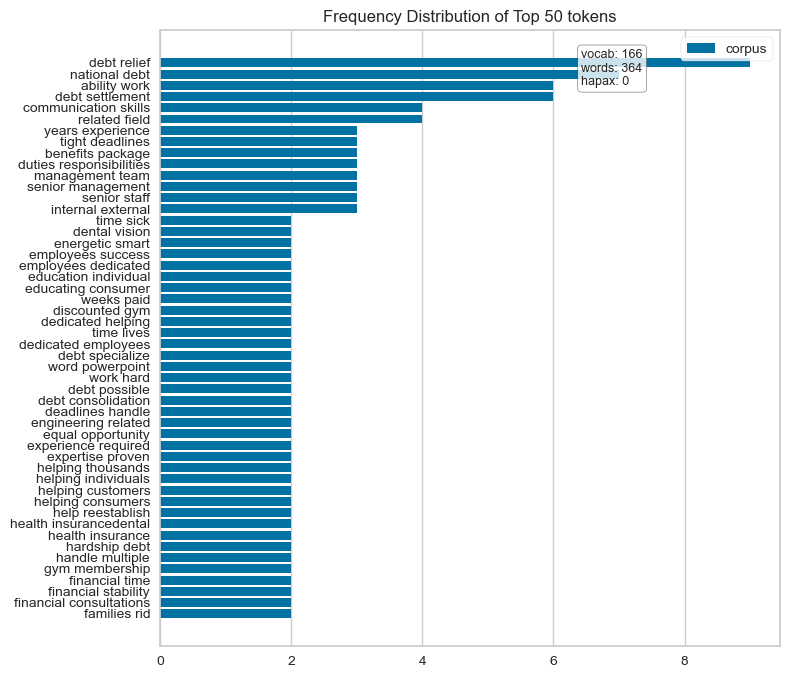

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [121]:
#Let's try to visualize counts of the tokens
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

vec = CountVectorizer(min_df= 2 , stop_words = 'english' , ngram_range = (2,2))
docs = vec.fit_transform(df_ny.Job_Desc)
features = vec.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='h' , size = (800,800))
visualizer.fit(docs)
visualizer.show()

In [122]:
#Now let's take average of minimal and maximal salary find its median

df_ny['avg_sal'] = (df_ny['Min_Salary'] + df_ny['Max_Salary'])//2

In [123]:
#Median avg annual salary
print(f"Median average annual salary is {df_ny['avg_sal'].median()}")
median_sal = df_ny['avg_sal'].median()
df_ny['is_higher'] = [1 if i > median_sal else 0 for i in df_ny.avg_sal]
df_ny.to_csv("train_data.csv" , index = False)
test_df.to_csv('test_data.csv' , index = False)

Median average annual salary is 91898.0
